In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd '/content/drive/My Drive/WhiteFurredMice_Dataset/Dataset'

/content/drive/My Drive/WhiteFurredMice_Dataset/Dataset


In [ ]:
!pwd

/content/drive/My Drive/WhiteFurredMice_Dataset/Dataset


## Step 1: Data Loading and Cleaning + Step 2: Data Preprocessing - split the data into training and test sets.



In [ ]:
import json
import os
import cv2
from sklearn.model_selection import train_test_split

# Load JSON data
with open('eyes_detection_data.json', 'r') as f:
    eyes_data = json.load(f)

with open('face_detection_data.json', 'r') as f:
    face_data = json.load(f)

# Split data into train and test sets
face_keys = list(face_data.keys())
train_face_keys, test_face_keys = train_test_split(face_keys, test_size=0.2, random_state=42)

# Prepare train and test dictionaries
train_face_data = {key: face_data[key] for key in train_face_keys}
test_face_data = {key: face_data[key] for key in test_face_keys}

# Convert annotations to YOLO format
def convert_to_yolo_format(data, output_dir, img_dir):
    os.makedirs(output_dir, exist_ok=True)
    for img_name, annotations in data.items():
        img_path = os.path.join(img_dir, img_name)
        height, width, _ = cv2.imread(img_path).shape

        with open(os.path.join(output_dir, os.path.splitext(img_name)[0] + '.txt'), 'w') as f:
            for annotation in annotations:
                bbox = annotation['Boundingbox']
                label = 0  # Assuming single class for face detection

                x_center = (int(bbox['x']) + int(bbox['w']) / 2) / width
                y_center = (int(bbox['y']) + int(bbox['h']) / 2) / height
                w = int(bbox['w']) / width
                h = int(bbox['h']) / height

                f.write(f"{label} {x_center} {y_center} {w} {h}\n")

# Convert and save annotations
convert_to_yolo_format(train_face_data, 'PyTorch-YOLOv3/train_labels', 'Face_detection')
convert_to_yolo_format(test_face_data, 'PyTorch-YOLOv3/test_labels', 'Face_detection')


## Step 3: Face Detection Using YOLO v3

Visualize individual images from the dataset

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# Function to visualize the image with their corresponding ground truth labels
def visualize_annotations(image_dir, label_dir):
    img_files = [file for file in Path(image_dir).glob('*.png') if (Path(label_dir) / f"{file.stem}.txt").exists()]
    label_files = {file.stem: file for file in Path(label_dir).glob('*.txt')}

    for img_path in img_files:
        img_stem = img_path.stem
        label_path = label_files[img_stem]

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = img.shape

        with open(label_path, 'r') as f:
            labels = np.array([list(map(float, line.split())) for line in f])

        plt.imshow(img)
        ax = plt.gca()

        for label in labels:
            cls, x_center, y_center, width, height = label
            x_center *= img_w
            y_center *= img_h
            width *= img_w
            height *= img_h

            x1 = x_center - width / 2
            y1 = y_center - height / 2
            rect = plt.Rectangle((x1, y1), width, height, fill=False, color='green')
            ax.add_patch(rect)
            plt.text(x1, y1, f'{int(cls)}', color='green', fontsize=12)

        plt.show()

# Usage
image_dir = 'Face_detection'
label_dir = 'PyTorch-YOLOv3/train_labels'
visualize_annotations(image_dir, label_dir)


Face Detection using YOLO v3

In [ ]:
### Final Script

In [ ]:
import sys
sys.path.append('PyTorch-YOLOv3')

import os
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pytorchyolo.models import Darknet
from pytorchyolo.utils.utils import load_classes, non_max_suppression, rescale_boxes

import json
import os
import cv2
from sklearn.model_selection import train_test_split

# Load JSON data
with open('eyes_detection_data.json', 'r') as f:
    eyes_data = json.load(f)

with open('face_detection_data.json', 'r') as f:
    face_data = json.load(f)

# Splitting data into train and test sets
face_keys = list(face_data.keys())
train_face_keys, test_face_keys = train_test_split(face_keys, test_size=0.2, random_state=42)

# Preparing train and test dictionaries
train_face_data = {key: face_data[key] for key in train_face_keys}
test_face_data = {key: face_data[key] for key in test_face_keys}

# Converting annotations to YOLO format
def convert_to_yolo_format(data, output_dir, img_dir):
    os.makedirs(output_dir, exist_ok=True)
    for img_name, annotations in data.items():
        img_path = os.path.join(img_dir, img_name)
        height, width, _ = cv2.imread(img_path).shape

        with open(os.path.join(output_dir, os.path.splitext(img_name)[0] + '.txt'), 'w') as f:
            for annotation in annotations:
                bbox = annotation['Boundingbox']
                label = 0  # Assuming single class for face detection

                x_center = (int(bbox['x']) + int(bbox['w']) / 2) / width
                y_center = (int(bbox['y']) + int(bbox['h']) / 2) / height
                w = int(bbox['w']) / width
                h = int(bbox['h']) / height

                f.write(f"{label} {x_center} {y_center} {w} {h}\n")

# Converting and saving annotations
convert_to_yolo_format(train_face_data, 'PyTorch-YOLOv3/train_labels', 'Face_detection')
convert_to_yolo_format(test_face_data, 'PyTorch-YOLOv3/test_labels', 'Face_detection')

# Custom Dataset class
class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=416):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size

        self.img_files = [file for file in Path(img_dir).glob('*.png') if (Path(label_dir) / f"{file.stem}.txt").exists()]
        self.label_files = {file.stem: file for file in Path(label_dir).glob('*.txt')}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_path = self.img_files[index]
        img_stem = img_path.stem

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        label_path = self.label_files[img_stem]
        with open(label_path, 'r') as f:
            labels = np.array([list(map(float, line.split())) for line in f])

        # Rescale labels
        labels[:, 1:] *= self.img_size

        return img, torch.tensor(labels, dtype=torch.float32)

# IoU Calculation Function
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x1_min, y1_min = x1, y1
    x1_max, y1_max = x1 + w1, y1 + h1

    x2_min, y2_min = x2, y2
    x2_max, y2_max = x2 + w2, y2 + h2

    inter_x1 = max(x1_min, x2_min)
    inter_y1 = max(y1_min, y2_min)
    inter_x2 = min(x1_max, x2_max)
    inter_y2 = min(y1_max, y2_max)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area


# Custom YOLOLoss class
class YOLOLoss(nn.Module):

    # Initialising model parameters
    def __init__(self, anchors, num_classes, img_size=416):
        super(YOLOLoss, self).__init__()
        self.anchors = anchors
        self.num_classes = num_classes
        self.img_size = img_size
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.ce_loss = nn.CrossEntropyLoss()

    # Forward Propagation Function
    def forward(self, predictions, targets):
        device = predictions[0].device
        losses = []
        for i, prediction in enumerate(predictions):
            batch_size = prediction.size(0)
            grid_size = prediction.size(2)

            obj_mask, noobj_mask, tx, ty, tw, th, tconf, tcls = self.build_targets(prediction, targets, self.anchors[i], grid_size)

            # Getting the predicted bounding boxes, predicted confidence scores and predicted class
            pred_boxes = prediction[..., :4]
            pred_conf = torch.sigmoid(prediction[..., 4])
            pred_cls = prediction[..., 5:]

            tx, ty, tw, th = tx.unsqueeze(-1), ty.unsqueeze(-1), tw.unsqueeze(-1), th.unsqueeze(-1)
            target_boxes = torch.cat((tx, ty, tw, th), -1)

            # Calculating the Coordinate Loss, Confidence Loss and Class Probabilities loss
            coord_loss = self.mse_loss(pred_boxes[obj_mask], target_boxes[obj_mask])
            conf_loss = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask]) + self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            class_loss = self.ce_loss(pred_cls[obj_mask], tcls[obj_mask].long())

            loss = coord_loss + conf_loss + class_loss
            losses.append(loss)

        return sum(losses)

    # Function to build the target mask values, coordinates, confidence score and class probabilities
    def build_targets(self, prediction, targets, anchors, grid_size):
        device = prediction.device
        batch_size = prediction.size(0)
        num_anchors = len(anchors)

        obj_mask = torch.zeros(batch_size, num_anchors, grid_size, grid_size, dtype=torch.bool).to(device)
        noobj_mask = torch.ones(batch_size, num_anchors, grid_size, grid_size, dtype=torch.bool).to(device)
        tx = torch.zeros(batch_size, num_anchors, grid_size, grid_size).to(device)
        ty = torch.zeros(batch_size, num_anchors, grid_size, grid_size).to(device)
        tw = torch.zeros(batch_size, num_anchors, grid_size, grid_size).to(device)
        th = torch.zeros(batch_size, num_anchors, grid_size, grid_size).to(device)
        tconf = torch.zeros(batch_size, num_anchors, grid_size, grid_size).to(device)
        tcls = torch.zeros(batch_size, num_anchors, grid_size, grid_size).to(device)

        for b in range(batch_size):
            for t in range(targets[b].shape[0]):
                gx, gy, gw, gh = targets[b][t, 1:5] / self.img_size * grid_size
                gi, gj = int(gx), int(gy)
                for i, anchor in enumerate(anchors):
                    aw, ah = anchor
                    box_loss_scale = (2 - targets[b][t, 3] * targets[b][t, 4])

                    obj_mask[b, i, gj, gi] = 1
                    noobj_mask[b, i, gj, gi] = 0

                    tx[b, i, gj, gi] = gx - gi
                    ty[b, i, gj, gi] = gy - gj
                    tw[b, i, gj, gi] = torch.log(gw / aw + 1e-16)
                    th[b, i, gj, gi] = torch.log(gh / ah + 1e-16)
                    tconf[b, i, gj, gi] = 1
                    tcls[b, i, gj, gi] = int(targets[b][t, 0])

        return obj_mask, noobj_mask, tx, ty, tw, th, tconf, tcls

# Custom function to calculate the total loss
def compute_loss(predictions, targets, model):
    anchors = [
        [(10, 13), (16, 30), (33, 23)],
        [(30, 61), (62, 45), (59, 119)],
        [(116, 90), (156, 198), (373, 326)]
    ]
    yolo_loss = YOLOLoss(anchors=anchors, num_classes=1)
    return yolo_loss(predictions, targets)

# Function to train the last layer of the pretrained YOLO model
def train_yolo(model, train_loader, num_epochs=10, lr=1e-4):

    # Initializing and setting Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = [torch.tensor(label).to(device) for label in labels]

            optimizer.zero_grad()

            # Getting the output values
            outputs = model(imgs)

            # Computing the loss values
            loss = compute_loss(outputs, labels, model)

            # Backward poropagation to update the weights
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Saving the trained model
    torch.save(model.state_dict(), 'yolov3_trained.pth')


# Evaluation function for bounding box detection
def evaluate_model(model, dataloader, img_size=416):
    model.eval()
    all_ious = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            # Applying non max suppression to the model outputs
            outputs = non_max_suppression(outputs, conf_thres=0.5, iou_thres=0.4)

            for output, label in zip(outputs, labels):
                if output is not None:
                    pred_boxes = rescale_boxes(output[:, :4], img_size, imgs.shape[-2:])
                    true_boxes = label[:, 1:5]

                    for true_box in true_boxes:
                        ious = [calculate_iou(pred_box.cpu().numpy(), true_box.cpu().numpy()) for pred_box in pred_boxes]
                        max_iou = max(ious) if ious else 0
                        all_ious.append(max_iou)
                        print(f'True box: {true_box}')
                        print(f'Pred boxes: {pred_boxes}')
                        print(f'IoUs: {ious}')
                        print(f'Max IoU: {max_iou}')

    mean_iou = np.mean(all_ious)
    print(f'Mean IoU: {mean_iou:.4f}')


# Main script

# Seeting CUDA GPU is available otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading YOLO weights and config
model = Darknet('PyTorch-YOLOv3/config/yolov3.cfg').to(device)
model.load_darknet_weights('PyTorch-YOLOv3/weights/yolov3.weights')

# Loading the train and test datasets using the custom YOLODataset class
train_dataset = YOLODataset('Face_detection', 'PyTorch-YOLOv3/train_labels')
test_dataset = YOLODataset('Face_detection', 'PyTorch-YOLOv3/test_labels')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training
train_yolo(model, train_loader, num_epochs=10)

# Evaluating performance
evaluate_model(model, test_loader, img_size=416)


Epoch 1/10, Loss: 0.39913564920425415
Epoch 2/10, Loss: 0.24837687611579895
Epoch 3/10, Loss: 0.4690767526626587
Epoch 4/10, Loss: 2.4116690158843994
Epoch 5/10, Loss: 0.34961557388305664
Epoch 6/10, Loss: 0.14255109429359436
Epoch 7/10, Loss: 0.37072134017944336
Epoch 8/10, Loss: 0.5817273855209351
Epoch 9/10, Loss: 0.09419138729572296
Epoch 10/10, Loss: 0.23891200125217438
True box: tensor([314.2750, 329.9111, 272.3500, 347.8222])
Pred boxes: tensor([[305.7381, 318.9324, 324.2819, 341.8061],
        [322.8015, 329.0034, 326.6319, 336.4520],
        [315.3546, 329.1993, 318.9755, 336.4153],
        [315.1639, 336.4796, 318.9290, 344.2348],
        [322.6349, 336.6305, 326.4837, 344.2502],
        [318.9416, 318.5811, 338.0089, 342.0424],
        [259.0033, 298.6785, 362.3719, 378.9324],
        [322.8065, 321.8004, 326.9232, 328.6506],
        [315.2999, 322.0168, 319.0640, 328.8274],
        [307.7354, 329.1745, 311.3989, 336.2408],
        [305.9687, 331.8845, 323.5830, 356.3729],
 

In [ ]:
# Save the model
torch.save(model.state_dict(), 'improved_yolov3.pth')

# # To load the model later
# model = Darknet('PyTorch-YOLOv3/config/yolov3.cfg').to(device)
# model.load_state_dict(torch.load('improved_yolov3.pth'))
# model.eval()

Visualizing true bounding boxes and predicted bounding boxes

True box: (tensor(152.9667), tensor(155.2296), tensor(401.4833), tensor(510.3704))
[[tensor(273.2310), tensor(332.3783), tensor(288.7574), tensor(355.9753)], [tensor(229.8426), tensor(301.1386), tensor(323.6924), tensor(378.4489)], [tensor(273.3170), tensor(318.7688), tensor(289.5775), tensor(342.3272)], [tensor(275.3551), tensor(336.8994), tensor(278.5822), tensor(344.1866)], [tensor(275.3701), tensor(329.4704), tensor(278.6123), tensor(336.5346)], [tensor(267.9406), tensor(329.2614), tensor(271.0468), tensor(336.3866)], [tensor(282.6089), tensor(337.0024), tensor(286.1465), tensor(344.4383)], [tensor(282.4914), tensor(329.3533), tensor(286.0791), tensor(336.6111)], [tensor(267.9414), tensor(336.7477), tensor(271.0070), tensor(344.0587)], [tensor(275.0729), tensor(321.7768), tensor(278.7079), tensor(328.7545)], [tensor(275.3387), tensor(344.3438), tensor(278.6764), tensor(351.9323)], [tensor(267.8293), tensor(321.6416), tensor(271.1974), tensor(329.0735)], [tensor(259.5214), tensor(31

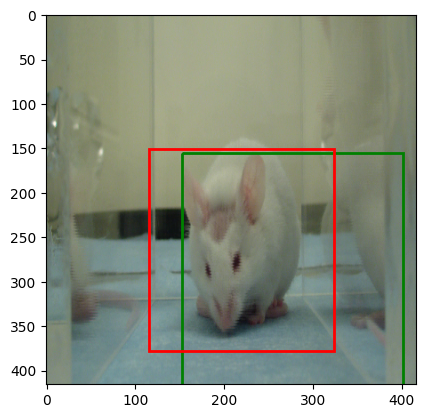

True box: (tensor(175.5000), tensor(136.7407), tensor(437.4500), tensor(471.4667))
[[tensor(265.0471), tensor(271.2661), tensor(353.0450), tensor(343.8524)], [tensor(256.5534), tensor(230.0459), tensor(361.5940), tensor(385.0307)], [tensor(307.1866), tensor(305.1840), tensor(310.9877), tensor(311.8594)], [tensor(307.1819), tensor(297.7724), tensor(310.9792), tensor(304.4298)], [tensor(304.0032), tensor(287.8486), tensor(323.1305), tensor(309.1468)], [tensor(304.0698), tensor(301.7787), tensor(322.5045), tensor(323.5974)], [tensor(314.4579), tensor(297.8139), tensor(318.4967), tensor(304.4576)], [tensor(314.3960), tensor(305.1152), tensor(318.3394), tensor(311.8802)], [tensor(306.9604), tensor(289.8085), tensor(310.9357), tensor(296.3627)], [tensor(299.4741), tensor(297.5537), tensor(303.3852), tensor(304.0554)], [tensor(299.5699), tensor(305.2891), tensor(303.3876), tensor(311.7443)], [tensor(307.2234), tensor(312.5773), tensor(310.9792), tensor(319.3623)], [tensor(314.3691), tensor(28

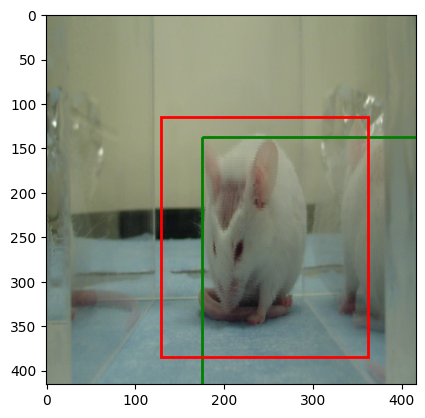

True box: (tensor(123.0667), tensor(160.6222), tensor(377.8667), tensor(565.0667))
[[tensor(242.6251), tensor(334.1078), tensor(258.5289), tensor(359.4412)], [tensor(251.6605), tensor(345.0175), tensor(254.7689), tensor(352.5159)], [tensor(258.9226), tensor(345.1748), tensor(262.2700), tensor(352.6228)], [tensor(258.9182), tensor(352.6199), tensor(262.3203), tensor(360.3119)], [tensor(251.5216), tensor(352.3015), tensor(254.6398), tensor(360.1781)], [tensor(242.6370), tensor(347.0029), tensor(258.1799), tensor(373.8744)], [tensor(256.2319), tensor(334.2446), tensor(272.3949), tensor(358.2807)], [tensor(251.6464), tensor(337.7678), tensor(254.8481), tensor(344.9800)], [tensor(258.9035), tensor(337.6508), tensor(262.3825), tensor(344.8170)], [tensor(208.4289), tensor(299.9815), tensor(284.0139), tensor(385.6584)], [tensor(244.0008), tensor(345.0697), tensor(246.9783), tensor(352.6144)], [tensor(251.4403), tensor(360.4403), tensor(254.6099), tensor(368.2899)], [tensor(258.8149), tensor(36

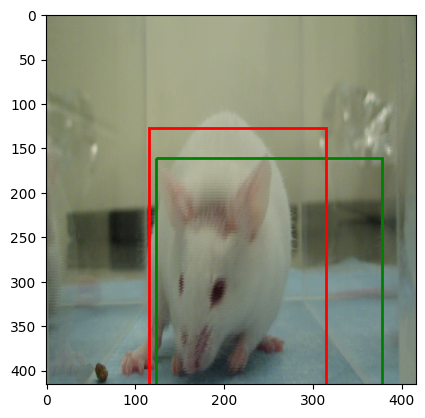

True box: (tensor(133.6833), tensor(151.7630), tensor(372.6667), tensor(485.7185))
[[tensor(241.6621), tensor(304.0956), tensor(258.1959), tensor(325.5685)], [tensor(251.0698), tensor(320.8359), tensor(254.3719), tensor(327.7335)], [tensor(251.1407), tensor(313.8094), tensor(254.3949), tensor(320.4652)], [tensor(243.5738), tensor(320.8288), tensor(246.8334), tensor(327.7301)], [tensor(243.6869), tensor(313.7255), tensor(246.8490), tensor(320.4376)], [tensor(241.8623), tensor(317.2239), tensor(257.6594), tensor(339.2317)], [tensor(208.1007), tensor(277.8002), tensor(282.8855), tensor(344.1293)], [tensor(243.5665), tensor(305.9437), tensor(246.8667), tensor(312.7158)], [tensor(258.4550), tensor(321.0729), tensor(262.1260), tensor(327.8788)], [tensor(250.9816), tensor(306.1049), tensor(254.4661), tensor(312.7006)], [tensor(258.3987), tensor(314.1362), tensor(262.0571), tensor(320.6483)], [tensor(236.0190), tensor(313.6633), tensor(239.1799), tensor(320.3056)], [tensor(251.1039), tensor(32

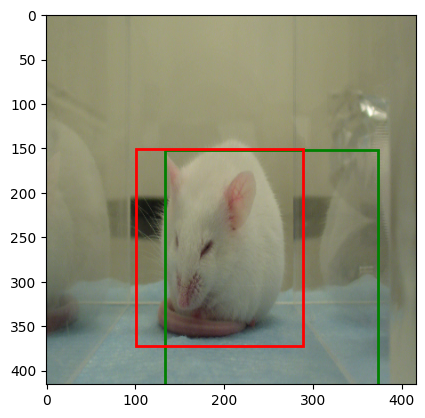

True box: (tensor(150.5833), tensor(63.1704), tensor(391.9500), tensor(301.2148))
[[tensor(267.2875), tensor(194.3411), tensor(270.8238), tensor(200.0338)], [tensor(258.0140), tensor(191.6960), tensor(274.9634), tensor(210.9525)], [tensor(267.3533), tensor(201.5434), tensor(270.8526), tensor(207.3725)], [tensor(259.6290), tensor(194.0335), tensor(263.1627), tensor(200.2245)], [tensor(235.0056), tensor(181.9229), tensor(316.8782), tensor(238.0710)], [tensor(274.8451), tensor(201.9861), tensor(278.5746), tensor(207.5863)], [tensor(272.6140), tensor(192.3020), tensor(290.1342), tensor(210.8456)], [tensor(274.8999), tensor(194.3455), tensor(278.5871), tensor(199.8574)], [tensor(227.5070), tensor(148.4075), tensor(324.2359), tensor(271.0663)], [tensor(259.5735), tensor(201.0943), tensor(263.0553), tensor(207.5650)], [tensor(267.1779), tensor(186.3907), tensor(270.7505), tensor(191.9453)], [tensor(274.7289), tensor(209.8762), tensor(278.7076), tensor(215.6715)], [tensor(259.5382), tensor(186

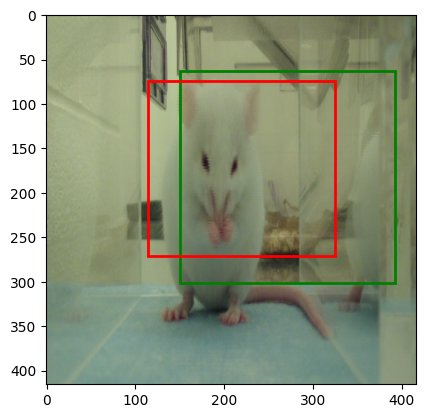

True box: (tensor(169.8667), tensor(138.2815), tensor(437.8833), tensor(444.8889))
[[tensor(304.7198), tensor(272.9656), tensor(322.9992), tensor(291.9901)], [tensor(315.0047), tensor(282.1156), tensor(318.6605), tensor(287.9471)], [tensor(307.2877), tensor(281.9022), tensor(310.9630), tensor(288.0849)], [tensor(314.9851), tensor(289.5254), tensor(318.7652), tensor(295.4863)], [tensor(307.2703), tensor(289.2527), tensor(311.1113), tensor(295.4197)], [tensor(263.7075), tensor(247.8402), tensor(353.9017), tensor(309.9779)], [tensor(307.2274), tensor(274.0899), tensor(310.8781), tensor(280.3079)], [tensor(255.4463), tensor(212.5067), tensor(362.3807), tensor(345.1232)], [tensor(304.4661), tensor(286.1698), tensor(323.0309), tensor(306.6585)], [tensor(299.7258), tensor(281.6715), tensor(303.4064), tensor(287.8227)], [tensor(322.5337), tensor(289.6026), tensor(326.5735), tensor(295.4446)], [tensor(314.8678), tensor(274.3662), tensor(318.6491), tensor(280.3035)], [tensor(322.4781), tensor(28

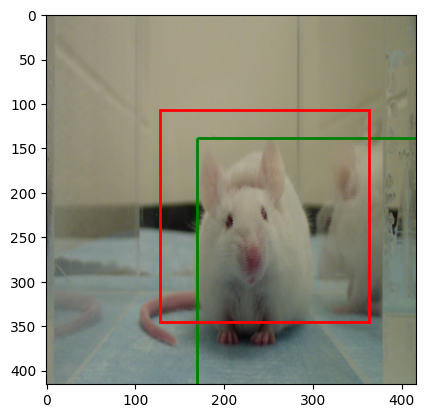

True box: (tensor(138.0167), tensor(136.3556), tensor(378.7333), tensor(531.9407))
[[tensor(257.5074), tensor(316.9337), tensor(274.2296), tensor(342.9681)], [tensor(233.1295), tensor(295.9992), tensor(314.5619), tensor(380.1462)], [tensor(259.5819), tensor(328.6952), tensor(262.7998), tensor(336.6543)], [tensor(224.5118), tensor(249.1727), tensor(322.6423), tensor(427.6710)], [tensor(266.9604), tensor(328.8746), tensor(270.3502), tensor(336.6407)], [tensor(259.6248), tensor(321.4524), tensor(262.8272), tensor(328.8820)], [tensor(266.9119), tensor(321.4305), tensor(270.3607), tensor(328.8493)], [tensor(259.4446), tensor(336.1462), tensor(262.6882), tensor(344.1657)], [tensor(266.9373), tensor(336.5043), tensor(270.4255), tensor(344.3680)], [tensor(257.3643), tensor(331.1483), tensor(273.7057), tensor(357.0013)], [tensor(274.5610), tensor(329.0595), tensor(278.3290), tensor(336.6100)], [tensor(252.1343), tensor(328.8903), tensor(255.1471), tensor(336.4250)], [tensor(274.5785), tensor(33

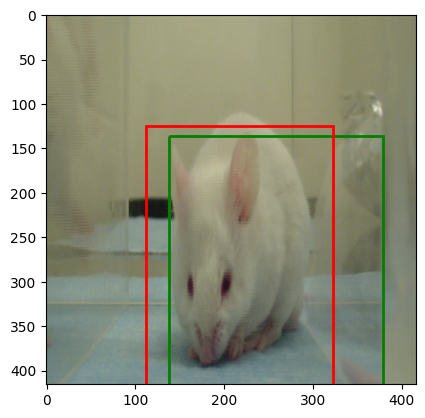

True box: (tensor(152.7500), tensor(139.0518), tensor(393.2500), tensor(472.2370))
[[tensor(272.4250), tensor(287.4614), tensor(290.0280), tensor(309.7054)], [tensor(275.3034), tensor(297.4318), tensor(278.8206), tensor(304.3347)], [tensor(229.2042), tensor(270.0776), tensor(324.0099), tensor(344.2264)], [tensor(275.0604), tensor(304.5747), tensor(278.6381), tensor(311.8678)], [tensor(282.6821), tensor(297.3564), tensor(286.2696), tensor(304.5267)], [tensor(271.9845), tensor(300.3461), tensor(289.6011), tensor(323.8552)], [tensor(267.8167), tensor(297.4279), tensor(271.1508), tensor(304.4253)], [tensor(282.5941), tensor(304.5609), tensor(286.2197), tensor(312.0508)], [tensor(259.6306), tensor(287.5973), tensor(275.3820), tensor(309.6419)], [tensor(267.7209), tensor(304.8967), tensor(271.1714), tensor(311.8956)], [tensor(275.3078), tensor(290.1436), tensor(278.9734), tensor(296.8759)], [tensor(267.6301), tensor(290.0531), tensor(271.0705), tensor(296.8675)], [tensor(282.4724), tensor(28

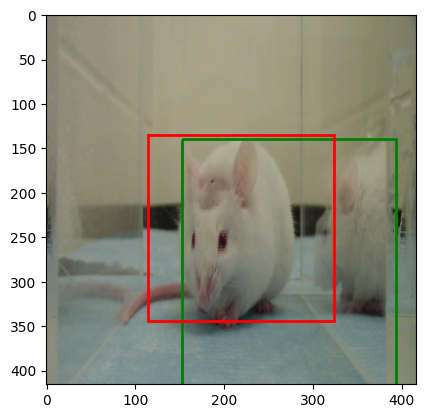

True box: (tensor(109.6333), tensor(169.0963), tensor(313.3000), tensor(525.0074))
[[tensor(210.3234), tensor(316.7496), tensor(224.2570), tensor(340.0857)], [tensor(219.1511), tensor(321.0266), tensor(222.0621), tensor(327.9463)], [tensor(211.6983), tensor(321.1014), tensor(214.6095), tensor(327.9946)], [tensor(211.8753), tensor(314.1068), tensor(214.7075), tensor(320.4016)], [tensor(219.3436), tensor(314.2470), tensor(222.2721), tensor(320.6517)], [tensor(210.4037), tensor(304.1669), tensor(224.5513), tensor(326.1954)], [tensor(211.4819), tensor(328.4426), tensor(214.5600), tensor(335.9513)], [tensor(204.0386), tensor(321.0476), tensor(206.8352), tensor(328.0988)], [tensor(219.0965), tensor(328.3176), tensor(222.1351), tensor(335.6175)], [tensor(204.0914), tensor(313.8000), tensor(206.8546), tensor(320.4928)], [tensor(176.5740), tensor(301.5732), tensor(249.6187), tensor(371.9135)], [tensor(226.7073), tensor(313.9611), tensor(230.0722), tensor(320.4807)], [tensor(226.6604), tensor(32

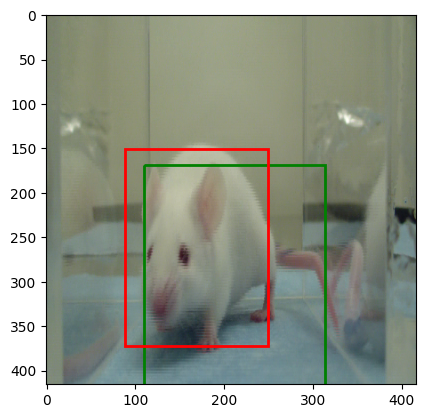

True box: (tensor(115.7000), tensor(152.9185), tensor(355.7667), tensor(481.0963))
[[tensor(226.9394), tensor(304.0345), tensor(242.1842), tensor(325.1389)], [tensor(235.5513), tensor(313.5111), tensor(238.6946), tensor(320.2968)], [tensor(235.4612), tensor(320.4828), tensor(238.6363), tensor(327.7152)], [tensor(242.7736), tensor(313.7845), tensor(246.0835), tensor(320.6276)], [tensor(199.4187), tensor(275.3132), tensor(286.2216), tensor(345.4866)], [tensor(242.7247), tensor(320.7398), tensor(246.0930), tensor(327.8560)], [tensor(235.5325), tensor(305.8926), tensor(238.6864), tensor(312.4723)], [tensor(228.1298), tensor(313.3672), tensor(231.1005), tensor(320.2027)], [tensor(228.0242), tensor(305.7326), tensor(231.0270), tensor(312.4369)], [tensor(242.6839), tensor(305.8530), tensor(246.1055), tensor(312.4550)], [tensor(227.1640), tensor(316.6542), tensor(241.9720), tensor(339.2322)], [tensor(240.5047), tensor(304.0497), tensor(255.9278), tensor(324.9838)], [tensor(228.0638), tensor(32

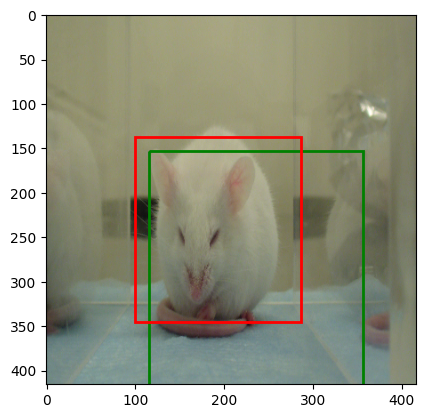

In [ ]:
import sys
sys.path.append('PyTorch-YOLOv3')

import os
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pytorchyolo.models import Darknet
from pytorchyolo.utils.utils import load_classes, non_max_suppression, rescale_boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Custom Dataset class
class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=416):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size

        self.img_files = [file for file in Path(img_dir).glob('*.png') if (Path(label_dir) / f"{file.stem}.txt").exists()]
        self.label_files = {file.stem: file for file in Path(label_dir).glob('*.txt')}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_path = self.img_files[index]
        img_stem = img_path.stem

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        label_path = self.label_files[img_stem]
        with open(label_path, 'r') as f:
            labels = np.array([list(map(float, line.split())) for line in f])

        # Rescale labels
        labels[:, 1:] *= self.img_size

        return img, torch.tensor(labels, dtype=torch.float32)


# Assuming predictions and true_boxes are provided and image is loaded
def visualize_boxes(image, predictions, true_boxes, img_size):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Plot the image
    ax.imshow(image)

    # Plot true boxes in green
    for box in true_boxes:
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)

    # Plot predicted boxes in red
    for pred in predictions:
        x1, y1, x2, y2 = pred
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Function to correctly rescale predicted boxes
def rescale_boxes_1(boxes, current_dim, original_dim):
    orig_h, orig_w = original_dim
    current_h, current_w = current_dim

    new_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = box

        x1 = x1 / current_w * orig_w
        y1 = y1 / current_h * orig_h
        x2 = x2 / current_w * orig_w
        y2 = y2 / current_h * orig_h

        new_boxes.append([x1, y1, x2, y2])
    return new_boxes

def visualize_predictions(imgs, labels, outputs, img_size=416):
    batch_size = imgs.size(0)
    for i in range(batch_size):
        fig, ax = plt.subplots(1)
        # Moving the tensor to CPU and convert to NumPy for visualization
        ax.imshow(imgs[i].permute(1, 2, 0).cpu().numpy())

        # Plotting true boxes
        true_boxes = labels[i].cpu()  # Moving the labels to CPU
        for box in true_boxes:
            x, y, w, h = box[1:]
            x1, y1, x2, y2 = x - w/2, y - h/2, x + w/2, y + h/2
            rect = plt.Rectangle((x1, y1), w, h, fill=False, linewidth=2, edgecolor='green')
            ax.add_patch(rect)
            print(f"True box: {(x1, y1, x1 + w, y1 + h)}")

        # Plotting predicted boxes
        if outputs[i] is not None:
            # Ensuring outputs are moved to CPU for processing
            pred_boxes = outputs[i][:, :4].cpu()

            # Image size fed to model is 416x416
            current_dim = (416, 416)

            # Rescaling pred_boxes
            pred_boxes_rescaled = rescale_boxes_1(pred_boxes, current_dim, (416, 416))
            print(pred_boxes_rescaled)

            # Converting list to numpy array for easier manipulation
            boxes = np.array(pred_boxes_rescaled)

            # Calculating the area of each bounding box
            areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

            # Finding the index of the bounding box with the largest area
            best_box_index = np.argmax(areas)

            # Getting the best bounding box
            best_box = boxes[best_box_index]

            x1, y1, x2, y2 = best_box

            x1 = x1 / 2
            y1 = y1 / 2

            width = x2 - x1
            height = y2 - y1

            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            print(f"Pred box: {(x1, y1, x2, y2)}")

        plt.show()




# Main script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Darknet('PyTorch-YOLOv3/config/yolov3.cfg').to(device)
model.load_state_dict(torch.load('yolov3_trained.pth'))
model.eval()

# Custom DataLoader providing batches of images and labels
test_dataset = YOLODataset('Face_detection', 'PyTorch-YOLOv3/test_labels')
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
img_size = 416

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = [label.to(device) for label in labels]
        outputs = model(imgs)
        outputs = non_max_suppression(outputs, conf_thres=0.5, iou_thres=0.4)

        visualize_predictions(imgs, labels, outputs, img_size=img_size)
        break  # visualize only the first batch


## Step 4: Grimace Scale Prediction Using Dilated Convolutional Neural Networks

### Eye Region Detection using a Dilated Convolutional Neural Network (CNN)

In [ ]:
# Clearing cache
import torch
torch.cuda.empty_cache()



*   Updated Training Code with more layers, Learning Rate Scheduler and AdamW Optimizer
*   Fine tuned hyperparameters and retraining model



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import json
from torch.optim.lr_scheduler import StepLR

# Custom EyeRegionDataset Class
class EyeRegionDataset(Dataset):
    def __init__(self, img_dir, json_file, img_size=416):
        self.img_dir = img_dir
        self.img_size = img_size
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.img_files = list(self.data.keys())

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        bbox = self.data[img_name][0]['Boundingbox']
        mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        x, y, w, h = int(bbox['x']), int(bbox['y']), int(bbox['w']), int(bbox['h'])
        mask[y:y+h, x:x+w] = 1.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask

# Class to design custom dilated CNN model architecture
class ImprovedDilatedCNN(nn.Module):
    def __init__(self):
        super(ImprovedDilatedCNN, self).__init__()
        layers = []
        in_channels = 3
        dilations = [1, 1, 2, 2, 4, 4, 8, 8, 16, 16, 32, 32]
        for d in dilations:
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
            in_channels = 64
        layers.append(nn.Conv2d(64, 1, kernel_size=1))
        layers.append(nn.Sigmoid())
        self.dilated_cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.dilated_cnn(x)

# Function to train the dilated CNN model
def train_improved_dilated_cnn(model, train_loader, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Using AdamW Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # Trying different optimizers, such as Adam
    # optimizer = optim.Adam(model.parameters(), lr=lr)

    # Using a learning rate ascheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

    # Using Binary Cross Entropy loss
    criterion = nn.BCELoss()

    # Train
    model.train()

    # Training for num_epochs
    for epoch in range(num_epochs):
        epoch_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            # getting model outputs
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            # Backward Propagation to update the weights
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

    # Saving the trained model
    torch.save(model.state_dict(), 'improved_dilated_cnn_model.pth')


# Main script, calling the DataLoader and the training module
train_dataset = EyeRegionDataset('Eyes_detection', 'eyes_detection_data.json')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
model = ImprovedDilatedCNN()
# train_improved_dilated_cnn(model, train_loader, num_epochs=15, lr=1e-4)
# train_improved_dilated_cnn(model, train_loader, num_epochs=50, lr=1e-5)
train_improved_dilated_cnn(model, train_loader, num_epochs=30, lr=1e-4)


Epoch 1/30, Loss: 0.46773524012635737
Epoch 2/30, Loss: 0.33785582289976235
Epoch 3/30, Loss: 0.2883756366722724
Epoch 4/30, Loss: 0.25803542838377114
Epoch 5/30, Loss: 0.22959289393004248
Epoch 6/30, Loss: 0.2090873047709465
Epoch 7/30, Loss: 0.18919800484881683
Epoch 8/30, Loss: 0.172041363795014
Epoch 9/30, Loss: 0.15425301452769952
Epoch 10/30, Loss: 0.14307812316452756
Epoch 11/30, Loss: 0.13264086820623455
Epoch 12/30, Loss: 0.12372335769674357
Epoch 13/30, Loss: 0.11831683238201282
Epoch 14/30, Loss: 0.11447440285016508
Epoch 15/30, Loss: 0.11079232219387503
Epoch 16/30, Loss: 0.10446698941728648
Epoch 17/30, Loss: 0.10190713098820518
Epoch 18/30, Loss: 0.09663789971348118
Epoch 19/30, Loss: 0.09606228199075251
Epoch 20/30, Loss: 0.09056989607565544
Epoch 21/30, Loss: 0.0870838995803805
Epoch 22/30, Loss: 0.08576300729285269
Epoch 23/30, Loss: 0.08480425474836546
Epoch 24/30, Loss: 0.08250808398074963
Epoch 25/30, Loss: 0.0826422844958656
Epoch 26/30, Loss: 0.07976088727660038
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import json
from torch.optim.lr_scheduler import StepLR

# Custom EyeRegionDataset Class
class EyeRegionDataset(Dataset):
    def __init__(self, img_dir, json_file, img_size=416):
        self.img_dir = img_dir
        self.img_size = img_size
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.img_files = list(self.data.keys())

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        bbox = self.data[img_name][0]['Boundingbox']
        mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        x, y, w, h = int(bbox['x']), int(bbox['y']), int(bbox['w']), int(bbox['h'])
        mask[y:y+h, x:x+w] = 1.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask

# Class to design custom dilated CNN model architecture
class ImprovedDilatedCNN(nn.Module):
    def __init__(self):
        super(ImprovedDilatedCNN, self).__init__()
        layers = []
        in_channels = 3
        dilations = [1, 1, 2, 2, 4, 4, 8, 8, 16, 16, 32, 32]
        for d in dilations:
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
            in_channels = 64
        layers.append(nn.Conv2d(64, 1, kernel_size=1))
        layers.append(nn.Sigmoid())
        self.dilated_cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.dilated_cnn(x)

# Function to avaluate the performance of the eye region detection model
def evaluate_improved_dilated_cnn(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            # Calculate IoU (Interscetion over Union)
            intersection = (outputs * masks).sum(dim=(1, 2, 3))
            union = outputs.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection
            iou = (intersection / union).mean().item()
            total_iou += iou
            num_samples += 1

    mean_iou = total_iou / num_samples
    print(f"Mean IoU: {mean_iou:.4f}")

# Loading the trained model
model = ImprovedDilatedCNN()
model.load_state_dict(torch.load('improved_dilated_cnn_model.pth'))

# Creating test dataset and loader
test_dataset = EyeRegionDataset('Eyes_detection', 'eyes_detection_data.json')
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluating the model
evaluate_improved_dilated_cnn(model, test_loader)


Mean IoU: 0.6315


True bounding box: (233, 370, 182, 45)
Predicted bounding box: (201, 344, 214, 71)


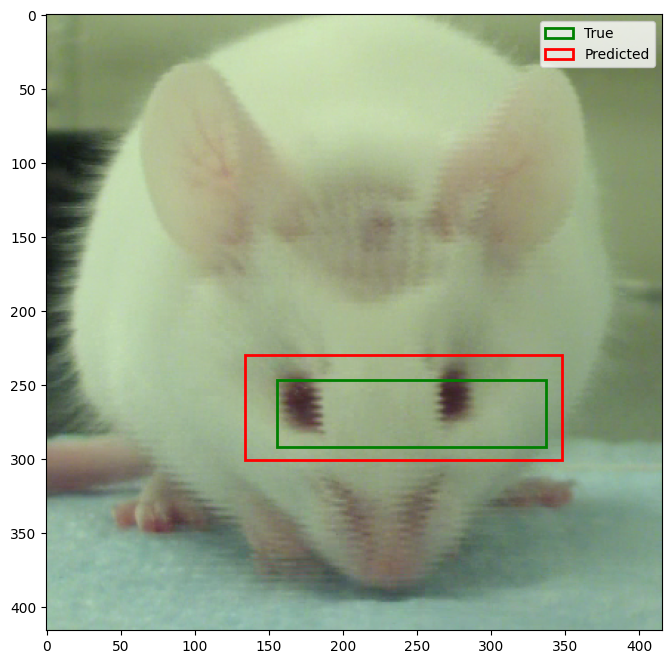

True bounding box: (191, 349, 224, 66)
Predicted bounding box: (186, 324, 229, 91)


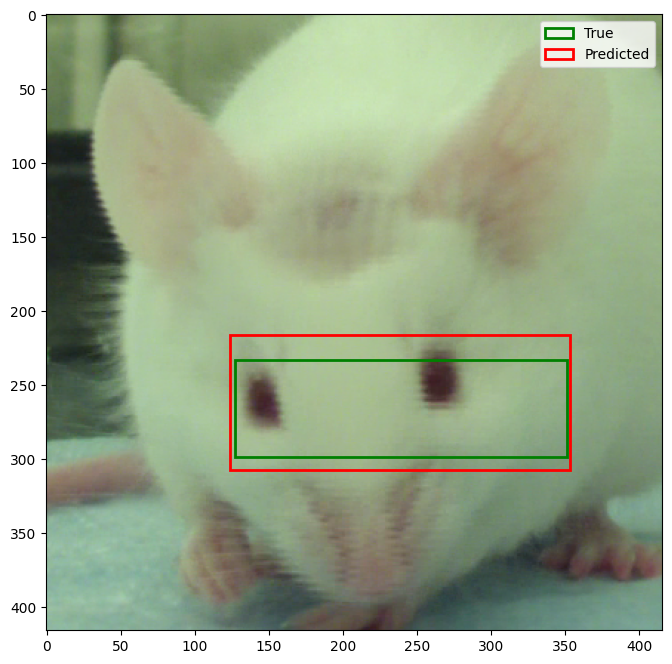

True bounding box: (213, 343, 202, 72)
Predicted bounding box: (207, 320, 208, 95)


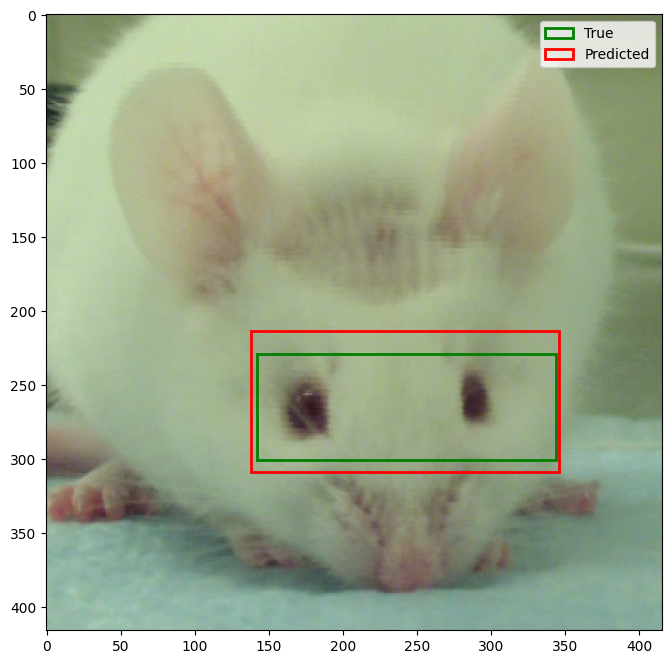

True bounding box: (250, 352, 165, 63)
Predicted bounding box: (224, 336, 191, 79)


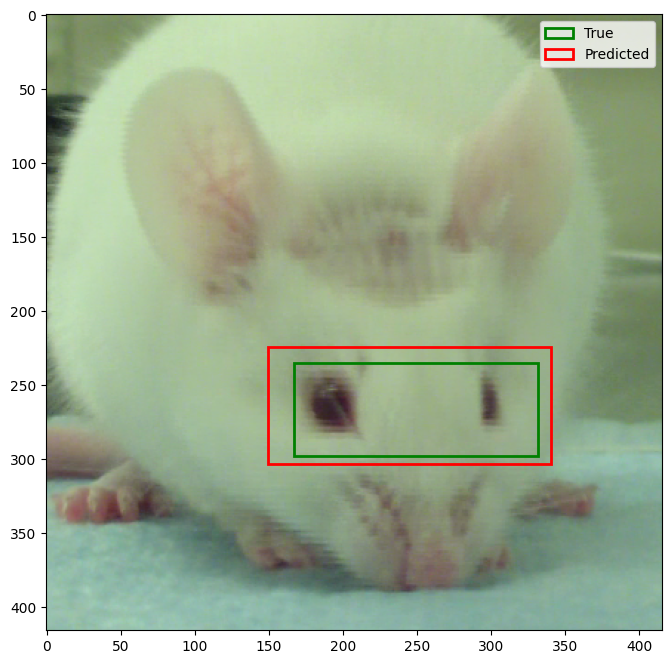

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import json
from torch.optim.lr_scheduler import StepLR

# Custom EyeRegionDataset Class
class EyeRegionDataset(Dataset):
    def __init__(self, img_dir, json_file, img_size=416):
        self.img_dir = img_dir
        self.img_size = img_size
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.img_files = list(self.data.keys())

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)

        bbox = self.data[img_name][0]['Boundingbox']
        mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        x, y, w, h = int(bbox['x']), int(bbox['y']), int(bbox['w']), int(bbox['h'])
        mask[y:y+h, x:x+w] = 1.0
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask

# Class to design custom dilated CNN model architecture
class ImprovedDilatedCNN(nn.Module):
    def __init__(self):
        super(ImprovedDilatedCNN, self).__init__()
        layers = []
        in_channels = 3
        dilations = [1, 1, 2, 2, 4, 4, 8, 8, 16, 16, 32, 32]
        for d in dilations:
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
            in_channels = 64
        layers.append(nn.Conv2d(64, 1, kernel_size=1))
        layers.append(nn.Sigmoid())
        self.dilated_cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.dilated_cnn(x)

# Evaluating performance and visualizing the outputs (true vs pred)
def evaluate_and_visualize(model, test_loader, num_images=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for i, (imgs, masks) in enumerate(test_loader):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)

            # Calculate IoU
            intersection = (outputs * masks).sum(dim=(1, 2, 3))
            union = outputs.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection
            iou = (intersection / union).mean().item()
            total_iou += iou
            num_samples += 1

            # Visualize true and predicted bounding boxes for the first num_images
            if i < num_images:
                visualize_bounding_boxes(imgs, masks, outputs)

    mean_iou = total_iou / num_samples
    print(f"Mean IoU: {mean_iou:.4f}")

# Function to visualize the true vs predicted bounding boxes
def visualize_bounding_boxes(images, true_masks, pred_masks):
    images = images.cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    pred_masks = pred_masks.cpu().numpy()

    for i in range(images.shape[0]):
        img = images[i].transpose(1, 2, 0)
        true_mask = true_masks[i, 0, :, :]
        pred_mask = pred_masks[i, 0, :, :]

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        # fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.imshow(img)

        # True bounding box
        true_coords = get_bounding_box(true_mask)
        if true_coords:
            print(f"True bounding box: {true_coords}")
            x, y, w, h = true_coords
            x = x / 1.5
            y = y / 1.5
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none', label='True')
            ax.add_patch(rect)

        # Predicted bounding box
        pred_coords = get_bounding_box(pred_mask)
        if pred_coords:
            print(f"Predicted bounding box: {pred_coords}")
            x, y, w, h = pred_coords
            x = x / 1.5
            y = y / 1.5
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none', label='Predicted')
            ax.add_patch(rect)

        plt.legend()
        plt.show()

def get_bounding_box(mask):
    # Finding the bounding box coordinates from the mask
    coords = np.argwhere(mask > 0.5)
    if coords.size == 0:
        return None
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return x_min, y_min, x_max - x_min, y_max - y_min

# Loading the trained model
model = ImprovedDilatedCNN()
model.load_state_dict(torch.load('improved_dilated_cnn_model.pth'))

# Creating test dataset and loader
test_dataset = EyeRegionDataset('Eyes_detection', 'eyes_detection_data.json')
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Evaluating the model and visualize results
evaluate_and_visualize(model, test_loader)


### Grimace Scale Prediction using a Neural Network

In [ ]:
# Updated Code with Lower Learning Rate and Gradient Clipping

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import json
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Loading the trained eye region detection model
class ImprovedDilatedCNN(nn.Module):
    def __init__(self):
        super(ImprovedDilatedCNN, self).__init__()
        layers = []
        in_channels = 3
        dilations = [1, 1, 2, 2, 4, 4, 8, 8, 16, 16, 32, 32]
        for d in dilations:
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
            in_channels = 64
        layers.append(nn.Conv2d(64, 1, kernel_size=1))
        layers.append(nn.Sigmoid())
        self.dilated_cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.dilated_cnn(x)

# Setting the device (CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the trained eye region detection model
eye_region_model = ImprovedDilatedCNN()
eye_region_model.load_state_dict(torch.load('improved_dilated_cnn_model.pth', map_location=device))
eye_region_model.to(device)
eye_region_model.eval()

# Custom GrimaceDataset class
class GrimaceDataset(Dataset):
    def __init__(self, data, img_dir, model):
        self.data = data
        self.img_dir = img_dir
        self.model = model
        self.samples = []
        for img_name, annotations in data.items():
            for annotation in annotations:
                self.samples.append((img_name, annotation))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, annotation = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

        # Predicting the mask
        with torch.no_grad():
            mask = self.model(image_tensor.to(device)).squeeze().cpu().numpy()

        # Applying mask to the image
        eye_region = image * mask[:, :, np.newaxis]

        # Resizing to the input size expected by the grimace scale model
        eye_region = cv2.resize(eye_region, (128, 128))
        eye_region = torch.tensor(eye_region, dtype=torch.float32).permute(2, 0, 1) / 255.0

        # Loading the ground truth labels
        label = int(annotation['GrimaceScale'])
        return eye_region, label

# Load the eyes_detection data
with open('eyes_detection_data.json', 'r') as f:
    eyes_data = json.load(f)

# Prepare dataset and dataloaders
train_eyes_data, test_eyes_data = train_test_split(list(eyes_data.items()), test_size=0.2, random_state=42)
train_eyes_dataset = GrimaceDataset(dict(train_eyes_data), 'Eyes_detection', eye_region_model)
test_eyes_dataset = GrimaceDataset(dict(test_eyes_data), 'Eyes_detection', eye_region_model)

train_eyes_loader = DataLoader(train_eyes_dataset, batch_size=16, shuffle=True)
test_eyes_loader = DataLoader(test_eyes_dataset, batch_size=16, shuffle=False)

# Defining the Grimace Scale Prediction Model architecture
class GrimaceCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(GrimaceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (128 // 32) * (128 // 32), 64), nn.ReLU(), nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training the Grimace Scale Prediction Model
grimace_model = GrimaceCNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(grimace_model.parameters(), lr=1e-5)  # Lower learning rate
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 50
for epoch in range(num_epochs):
    grimace_model.train()
    epoch_loss = 0
    for imgs, labels in train_eyes_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = grimace_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(grimace_model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_eyes_loader)}")

# Saving the trained model
torch.save(grimace_model.state_dict(), 'grimace_cnn.pth')

# Evaluating the performance of the model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return f1

f1 = evaluate_model(grimace_model, test_eyes_loader)
print(f'Weighted F1 Score: {f1}')


Epoch 1/50, Loss: 1.1725544235923073
Epoch 2/50, Loss: 1.1244952364401384
Epoch 3/50, Loss: 1.12181758555499
Epoch 4/50, Loss: 1.0903653199022467
Epoch 5/50, Loss: 1.0516349987550215
Epoch 6/50, Loss: 1.0106942198493265
Epoch 7/50, Loss: 0.9934487158601935
Epoch 8/50, Loss: 0.9572754057970914
Epoch 9/50, Loss: 0.9413399392908269
Epoch 10/50, Loss: 0.9267399581995878
Epoch 11/50, Loss: 0.9199213699861006
Epoch 12/50, Loss: 0.9150623169812289
Epoch 13/50, Loss: 0.9230641701004721
Epoch 14/50, Loss: 0.8917566180229187
Epoch 15/50, Loss: 0.8737406643954191
Epoch 16/50, Loss: 0.8990512002598156
Epoch 17/50, Loss: 0.8503036423162981
Epoch 18/50, Loss: 0.8495704705064947
Epoch 19/50, Loss: 0.8496120019392533
Epoch 20/50, Loss: 0.8620512214573947
Epoch 21/50, Loss: 0.8273588624867526
Epoch 22/50, Loss: 0.818175441568548
Epoch 23/50, Loss: 0.8391015356237238
Epoch 24/50, Loss: 0.8224644834345037
Epoch 25/50, Loss: 0.8074718085202304
Epoch 26/50, Loss: 0.8073575160720131
Epoch 27/50, Loss: 0.812

### Two-stage training process as described in the paper:


1.   Training a binary classifier to distinguish between no pain (value 0) and pain (value 2).
2.   Adapting the classifier to include the ambiguous middle category (value 1) and training it as a three-class classifier.


### Step 1: Binary Classifier Training (0 vs 2)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import json
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Loading the trained eye region detection model
class ImprovedDilatedCNN(nn.Module):
    def __init__(self):
        super(ImprovedDilatedCNN, self).__init__()
        layers = []
        in_channels = 3
        dilations = [1, 1, 2, 2, 4, 4, 8, 8, 16, 16, 32, 32]
        for d in dilations:
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
            in_channels = 64
        layers.append(nn.Conv2d(64, 1, kernel_size=1))
        layers.append(nn.Sigmoid())
        self.dilated_cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.dilated_cnn(x)

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the trained eye region detection model
eye_region_model = ImprovedDilatedCNN()
eye_region_model.load_state_dict(torch.load('improved_dilated_cnn_model.pth', map_location=device))
eye_region_model.to(device)
eye_region_model.eval()

# Custom BinaryGrimaceDataset class
class BinaryGrimaceDataset(Dataset):
    def __init__(self, data, img_dir, model):
        self.data = data
        self.img_dir = img_dir
        self.model = model
        self.samples = []
        for img_name, annotations in data.items():
            for annotation in annotations:
                if int(annotation['GrimaceScale']) in [0, 2]:  # Include only 0 and 2
                    self.samples.append((img_name, annotation))

        print(f"Total samples collected in dataset: {len(self.samples)}")
        for img_name, annotation in self.samples[:5]:  # Print the first 5 samples for verification
            print(f"Sample - img_name: {img_name}, GrimaceScale: {annotation['GrimaceScale']}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, annotation = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

        # Predicting the mask
        with torch.no_grad():
            mask = self.model(image_tensor.to(device)).squeeze().cpu().numpy()

        # Applying mask to the image
        eye_region = image * mask[:, :, np.newaxis]

        # Resizing to the input size expected by the grimace scale model
        eye_region = cv2.resize(eye_region, (128, 128))
        eye_region = torch.tensor(eye_region, dtype=torch.float32).permute(2, 0, 1) / 255.0

        label = int(annotation['GrimaceScale'])
        label = 0 if label == 0 else 1  # Convert to binary classification: 0 -> 0, 2 -> 1
        return eye_region, label

# Loading the eyes_detection data json file
with open('eyes_detection_data.json', 'r') as f:
    eyes_data = json.load(f)

# Separating data by class
class_0_data = {k: v for k, v in eyes_data.items() if any(int(ann['GrimaceScale']) == 0 for ann in v)}
class_2_data = {k: v for k, v in eyes_data.items() if any(int(ann['GrimaceScale']) == 2 for ann in v)}

print(f"Total samples for class 0: {len(class_0_data)}")
print(f"Total samples for class 2: {len(class_2_data)}")

# Ensuring that we have enough samples for a split
min_samples_required = 10

if len(class_0_data) < min_samples_required or len(class_2_data) < min_samples_required:
    raise ValueError("Not enough samples for one or more classes.")

# Splitting each class separately with a smaller test size to ensure enough samples
test_size = 0.1 if min(len(class_0_data), len(class_2_data)) < 20 else 0.2

train_class_0_data, test_class_0_data = train_test_split(list(class_0_data.items()), test_size=test_size, random_state=42)
train_class_2_data, test_class_2_data = train_test_split(list(class_2_data.items()), test_size=test_size, random_state=42)

print(f"Training samples for class 0: {len(train_class_0_data)}")
print(f"Training samples for class 2: {len(train_class_2_data)}")
print(f"Testing samples for class 0: {len(test_class_0_data)}")
print(f"Testing samples for class 2: {len(test_class_2_data)}")

# Combining the splits
train_eyes_data = train_class_0_data + train_class_2_data
test_eyes_data = test_class_0_data + test_class_2_data

# Creating train and test datasets
train_eyes_dataset_binary = BinaryGrimaceDataset(dict(train_eyes_data), 'Eyes_detection', eye_region_model)
test_eyes_dataset_binary = BinaryGrimaceDataset(dict(test_eyes_data), 'Eyes_detection', eye_region_model)

print(f"Total training samples: {len(train_eyes_dataset_binary)}")
print(f"Total testing samples: {len(test_eyes_dataset_binary)}")

if len(train_eyes_dataset_binary) == 0 or len(test_eyes_dataset_binary) == 0:
    raise ValueError("Not enough samples for training or testing after the split.")

train_eyes_loader_binary = DataLoader(train_eyes_dataset_binary, batch_size=16, shuffle=True)
test_eyes_loader_binary = DataLoader(test_eyes_dataset_binary, batch_size=16, shuffle=False)

# Defining the Binary Grimace Scale Prediction Model architecture
class BinaryGrimaceCNN(nn.Module):
    def __init__(self):
        super(BinaryGrimaceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (128 // 32) * (128 // 32), 64), nn.ReLU(), nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.Linear(64, 2)  # Linear layer with 2 outputs for Binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training the Binary Grimace Scale Prediction Model
binary_grimace_model = BinaryGrimaceCNN().to(device)
criterion_binary = nn.CrossEntropyLoss()
optimizer_binary = torch.optim.Adam(binary_grimace_model.parameters(), lr=1e-4)
scheduler_binary = StepLR(optimizer_binary, step_size=10, gamma=0.5)

num_epochs_binary = 100
best_f1 = 0.0  # Keeping track of the best F1 score

# Evaluating the performance of the model (F1 Score)
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return f1

for epoch in range(num_epochs_binary):
    binary_grimace_model.train()
    epoch_loss = 0
    for imgs, labels in train_eyes_loader_binary:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer_binary.zero_grad()
        # getting model outputs
        outputs = binary_grimace_model(imgs)
        # loss calculation and backward propagation
        loss = criterion_binary(outputs, labels)
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(binary_grimace_model.parameters(), max_norm=1.0)
        optimizer_binary.step()

        epoch_loss += loss.item()

    scheduler_binary.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs_binary}, Loss: {epoch_loss/len(train_eyes_loader_binary)}")

        # Evaluate the binary model
        f1_binary = evaluate_model(binary_grimace_model, test_eyes_loader_binary)
        print(f'Weighted F1 Score for binary classification at epoch {epoch+1}: {f1_binary}')

        # Save the best model based on F1 score
        if f1_binary > best_f1:
            best_f1 = f1_binary
            torch.save(binary_grimace_model.state_dict(), 'best_binary_grimace_cnn.pth')

print(f'Best Weighted F1 Score for binary classification: {best_f1}')

# Load the best model for final evaluation
binary_grimace_model.load_state_dict(torch.load('best_binary_grimace_cnn.pth'))
f1_binary_final = evaluate_model(binary_grimace_model, test_eyes_loader_binary)
print(f'Final Weighted F1 Score for binary classification: {f1_binary_final}')


Total samples for class 0: 552
Total samples for class 2: 193
Training samples for class 0: 441
Training samples for class 2: 154
Testing samples for class 0: 111
Testing samples for class 2: 39
Total samples collected in dataset: 595
Sample - img_name: animalImage_827.png, GrimaceScale: 0
Sample - img_name: animalImage_1032.png, GrimaceScale: 0
Sample - img_name: animalImage_361.png, GrimaceScale: 0
Sample - img_name: animalImage_19.png, GrimaceScale: 0
Sample - img_name: animalImage_761.png, GrimaceScale: 0
Total samples collected in dataset: 150
Sample - img_name: animalImage_1073.png, GrimaceScale: 0
Sample - img_name: animalImage_165.png, GrimaceScale: 0
Sample - img_name: animalImage_231.png, GrimaceScale: 0
Sample - img_name: animalImage_143.png, GrimaceScale: 0
Sample - img_name: animalImage_574.png, GrimaceScale: 0
Total training samples: 595
Total testing samples: 150
Epoch 5/100, Loss: 0.5447571991305602
Weighted F1 Score for binary classification at epoch 5: 0.5870746108427

### Step 2: Three Class Classifier Traning (0, 1, 2)

In [ ]:
# Updated Code with Lower Learning Rate and Gradient Clipping

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
import json
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Loading the trained eye region detection model
class ImprovedDilatedCNN(nn.Module):
    def __init__(self):
        super(ImprovedDilatedCNN, self).__init__()
        layers = []
        in_channels = 3
        dilations = [1, 1, 2, 2, 4, 4, 8, 8, 16, 16, 32, 32]
        for d in dilations:
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
            in_channels = 64
        layers.append(nn.Conv2d(64, 1, kernel_size=1))
        layers.append(nn.Sigmoid())
        self.dilated_cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.dilated_cnn(x)

# Setthing device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the trained eye region detection model
eye_region_model = ImprovedDilatedCNN()
eye_region_model.load_state_dict(torch.load('improved_dilated_cnn_model.pth', map_location=device))
eye_region_model.to(device)
eye_region_model.eval()

# Custom GrimaceDataset class
class GrimaceDataset(Dataset):
    def __init__(self, data, img_dir, model):
        self.data = data
        self.img_dir = img_dir
        self.model = model
        self.samples = []
        for img_name, annotations in data.items():
            for annotation in annotations:
                self.samples.append((img_name, annotation))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, annotation = self.samples[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0

        # Predicting mask
        with torch.no_grad():
            mask = self.model(image_tensor.to(device)).squeeze().cpu().numpy()

        # Applying mask to the image
        eye_region = image * mask[:, :, np.newaxis]

        # Resizing to the input size expected by the grimace scale model
        eye_region = cv2.resize(eye_region, (128, 128))
        eye_region = torch.tensor(eye_region, dtype=torch.float32).permute(2, 0, 1) / 255.0

        label = int(annotation['GrimaceScale'])
        return eye_region, label

# Loading the eyes_detection data
with open('eyes_detection_data.json', 'r') as f:
    eyes_data = json.load(f)

# Preparing train and test dataset and dataloaders
train_eyes_data, test_eyes_data = train_test_split(list(eyes_data.items()), test_size=0.2, random_state=42)
train_eyes_dataset = GrimaceDataset(dict(train_eyes_data), 'Eyes_detection', eye_region_model)
test_eyes_dataset = GrimaceDataset(dict(test_eyes_data), 'Eyes_detection', eye_region_model)

train_eyes_loader = DataLoader(train_eyes_dataset, batch_size=16, shuffle=True)
test_eyes_loader = DataLoader(test_eyes_dataset, batch_size=16, shuffle=False)

# Defining the Grimace Scale Prediction Model architecture
class GrimaceCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(GrimaceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (128 // 32) * (128 // 32), 64), nn.ReLU(), nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training the Grimace Scale Prediction Model
grimace_model = GrimaceCNN(num_classes=3).to(device)
# Cross Entropy loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(grimace_model.parameters(), lr=1e-5)  # Lower learning rate than before (updated from 1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 50
for epoch in range(num_epochs):
    grimace_model.train()
    epoch_loss = 0
    for imgs, labels in train_eyes_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # Model ouputs
        outputs = grimace_model(imgs)
        # Loss calc and backprop
        loss = criterion(outputs, labels)
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(grimace_model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_eyes_loader)}")

# Saving the trained model
torch.save(grimace_model.state_dict(), 'grimace_cnn.pth')

# Evaluate performance using F1 Score
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return f1

f1 = evaluate_model(grimace_model, test_eyes_loader)
print(f'Weighted F1 Score: {f1}')


Epoch 1/50, Loss: 1.1725544235923073
Epoch 2/50, Loss: 1.1244952364401384
Epoch 3/50, Loss: 1.12181758555499
Epoch 4/50, Loss: 1.0903653199022467
Epoch 5/50, Loss: 1.0516349987550215
Epoch 6/50, Loss: 1.0106942198493265
Epoch 7/50, Loss: 0.9934487158601935
Epoch 8/50, Loss: 0.9572754057970914
Epoch 9/50, Loss: 0.9413399392908269
Epoch 10/50, Loss: 0.9267399581995878
Epoch 11/50, Loss: 0.9199213699861006
Epoch 12/50, Loss: 0.9150623169812289
Epoch 13/50, Loss: 0.9230641701004721
Epoch 14/50, Loss: 0.8917566180229187
Epoch 15/50, Loss: 0.8737406643954191
Epoch 16/50, Loss: 0.8990512002598156
Epoch 17/50, Loss: 0.8503036423162981
Epoch 18/50, Loss: 0.8495704705064947
Epoch 19/50, Loss: 0.8496120019392533
Epoch 20/50, Loss: 0.8620512214573947
Epoch 21/50, Loss: 0.8273588624867526
Epoch 22/50, Loss: 0.818175441568548
Epoch 23/50, Loss: 0.8391015356237238
Epoch 24/50, Loss: 0.8224644834345037
Epoch 25/50, Loss: 0.8074718085202304
Epoch 26/50, Loss: 0.8073575160720131
Epoch 27/50, Loss: 0.81

### Testing on a random input image

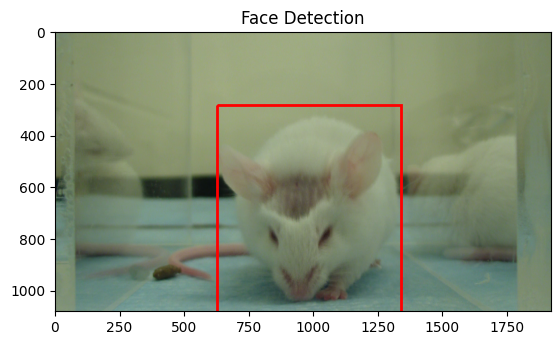

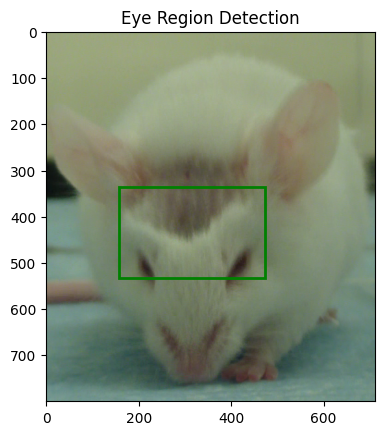

Predicted Grimace Scale: 2


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pytorchyolo.models import Darknet
from pytorchyolo.utils.utils import non_max_suppression, rescale_boxes

# Defining the models (same architecture as used during training)
class ImprovedDilatedCNN(nn.Module):
    def __init__(self):
        super(ImprovedDilatedCNN, self).__init__()
        layers = []
        in_channels = 3
        dilations = [1, 1, 2, 2, 4, 4, 8, 8, 16, 16, 32, 32]
        for d in dilations:
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
            in_channels = 64
        layers.append(nn.Conv2d(64, 1, kernel_size=1))
        layers.append(nn.Sigmoid())
        self.dilated_cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.dilated_cnn(x)

class GrimaceCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(GrimaceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (128 // 32) * (128 // 32), 64), nn.ReLU(), nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)  # Three-class classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class BinaryGrimaceCNN(nn.Module):
    def __init__(self):
        super(BinaryGrimaceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (128 // 32) * (128 // 32), 64), nn.ReLU(), nn.Dropout(0.5),
            nn.BatchNorm1d(64),
            nn.Linear(64, 2)  # Binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Loading the models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Face detection model
face_model = Darknet('PyTorch-YOLOv3/config/yolov3.cfg').to(device)
face_model.load_state_dict(torch.load('yolov3_trained.pth', map_location=device))
face_model.eval()

# Eye region detection model
eye_region_model = ImprovedDilatedCNN().to(device)
eye_region_model.load_state_dict(torch.load('improved_dilated_cnn_model.pth', map_location=device))
eye_region_model.eval()

# Grimace scale prediction model
grimace_model = GrimaceCNN(num_classes=3).to(device)
grimace_model.load_state_dict(torch.load('grimace_cnn.pth', map_location=device))
grimace_model.eval()
# grimace_model = BinaryGrimaceCNN().to(device)
# grimace_model.load_state_dict(torch.load('best_binary_grimace_cnn.pth', map_location=device))
# grimace_model.eval()

# Function to load and preprocess image
def load_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, image_rgb

# Function to perform face detection and visualize result
def detect_face(image, model):
    # Preprocess the image for YOLO
    img_resized = cv2.resize(image, (416, 416))
    img_transformed = torch.from_numpy(img_resized.transpose(2, 0, 1)).float().div(255.0).unsqueeze(0).to(device)

    with torch.no_grad():
        detections = model(img_transformed)
        detections = non_max_suppression(detections, conf_thres=0.5, iou_thres=0.4)

    # Extract bounding box
    detection = detections[0]
    if detection is not None:
        detection = rescale_boxes(detection, 416, image.shape[:2])
        detection = detection.cpu().numpy()

        for det in detection:
            x1, y1, x2, y2, conf = det[:5]
            x1 = x1 // 2
            y1 = y1 // 4
            # Visualize bounding box
            fig, ax = plt.subplots(1)
            ax.imshow(image)
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.title("Face Detection")
            plt.show()

            # Return the bounding box coordinates
            return int(x1), int(y1), int(x2), int(y2)
    return None

# Function to perform eye region detection and visualize result
def detect_eye_region(image, face_bbox, model):
    x1, y1, x2, y2 = face_bbox
    face = image[y1:y2, x1:x2]
    face_resized = cv2.resize(face, (416, 416))
    face_tensor = torch.from_numpy(face_resized.transpose(2, 0, 1)).float().unsqueeze(0).div(255.0).to(device)

    with torch.no_grad():
        mask = model(face_tensor).squeeze().cpu().numpy()

    # # Print mask statistics
    # print("Mask statistics:")
    # print(f"Min value: {np.min(mask)}")
    # print(f"Max value: {np.max(mask)}")
    # print(f"Mean value: {np.mean(mask)}")

    # Normalize the mask
    mask_normalized = (mask - np.min(mask)) / (np.max(mask) - np.min(mask))

    # Apply threshold to the mask
    mask_thresholded = (mask_normalized > 0.5).astype(np.float32)

    # Resize mask to match face region
    mask_resized = cv2.resize(mask_thresholded, (face.shape[1], face.shape[0]))

    # Find the bounding box of the eye region in the mask
    y_indices, x_indices = np.where(mask_resized > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        print("No eye region detected.")
        return face  # Return the face image if no eye region is detected

    y1_eye, y2_eye = np.min(y_indices), np.max(y_indices)
    x1_eye, x2_eye = np.min(x_indices), np.max(x_indices)
    # x1_eye = x1_eye // 2
    # y1_eye = y1_eye // 2
    # y2_eye = int(y2_eye / 1.25)
    # x2_eye = int(x2_eye / 1.5)
    x1_eye = x1_eye // 2
    y1_eye = y1_eye // 2
    y2_eye = int(y2_eye / 1.5)
    x2_eye = int(x2_eye / 1.5)


    # Visualize the eye region bounding box
    fig, ax = plt.subplots(1)
    ax.imshow(face)
    rect = patches.Rectangle((x1_eye, y1_eye), x2_eye - x1_eye, y2_eye - y1_eye, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    plt.title("Eye Region Detection")
    plt.show()

    # Extract the eye region using the bounding box
    eye_region = face[y1_eye:y2_eye, x1_eye:x2_eye]
    ax.imshow(eye_region)
    return eye_region

# Function to predict grimace scale
def predict_grimace_scale(eye_region, model):
    eye_region_resized = cv2.resize(eye_region, (128, 128))
    eye_region_tensor = torch.from_numpy(eye_region_resized.transpose(2, 0, 1)).float().unsqueeze(0).div(255.0).to(device)

    with torch.no_grad():
        outputs = model(eye_region_tensor)
        _, predicted = torch.max(outputs, 1)
        grimace_scale = predicted.item()
    return grimace_scale

# Main function to process an image and display results
def process_image(image_path):
    image, image_rgb = load_image(image_path)

    # Face detection
    face_bbox = detect_face(image_rgb, face_model)
    if face_bbox is None:
        print("No face detected.")
        return

    # Eye region detection
    eye_region = detect_eye_region(image_rgb, face_bbox, eye_region_model)

    # Grimace scale prediction
    grimace_scale = predict_grimace_scale(eye_region, grimace_model)
    print(f"Predicted Grimace Scale: {grimace_scale}")

# Example usage
image_path = "Face_detection/animalImage_2162.png"  # Replace with the path to your image
# image_path = "Face_detection/animalImage_1768.png"  # Replace with the path to your image
# image_path = "Face_detection/animalImage_1.png"  # Replace with the path to your image
process_image(image_path)
